# Gesture Classification

This notebook is used to train classification models from csv dataset. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
# set up
dataset = 'datasets/HandLandmarks1000.csv'

model_save_path = 'models/keypoint_classifier.hdf5'
tflite_save_path = 'models/keypoint_classifier.tflite'

LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted'] 
NUM_CLASSES = len(LABELS)

## Dataset Preparation

In [3]:
# Load the datasets and apply train_test_split
df = pd.read_csv(dataset, header=None, dtype='float32')

y_dataset = df.iloc[:, 0].values.astype('int32')
X_dataset = df.iloc[:, 1:].values

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [4]:
y_train

array([11, 10,  4, ...,  5,  0,  7])

In [5]:
X_train

array([[ 0.        ,  0.37109262,  0.37854972, ...,  0.3962902 ,
         0.24901247, -0.02008493],
       [ 1.        ,  0.75501627,  0.43193364, ...,  0.7827449 ,
         0.32504714, -0.0193696 ],
       [ 1.        ,  0.5183266 ,  0.70544964, ...,  0.39134496,
         0.6377189 , -0.05509105],
       ...,
       [ 1.        ,  0.68599534,  0.68687624, ...,  0.7628145 ,
         0.5603018 , -0.05664702],
       [ 0.        ,  0.39546585,  0.6009588 , ...,  0.506768  ,
         0.7457703 , -0.02445626],
       [ 1.        ,  0.75015366,  0.48553923, ...,  0.8280829 ,
         0.37854958, -0.03483592]], dtype=float32)

In [6]:
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(9000,) (9000, 64) (3000,) (3000, 64)


## Model Building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3 + 1, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [11]:
es_callback

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000




64/71 [==========================>...] - ETA: 0s - loss: 2.4232 - accuracy: 0.1810
Epoch 1: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 3s 9ms/step - loss: 2.4021 - accuracy: 0.1870 - val_loss: 2.4413 - val_accuracy: 0.1707
Epoch 2/1000
49/71 [===================>..........] - ETA: 0s - loss: 2.0318 - accuracy: 0.3033

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/71 [==========================>...] - ETA: 0s - loss: 2.0180 - accuracy: 0.3093
Epoch 2: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 2.0083 - accuracy: 0.3136 - val_loss: 2.2936 - val_accuracy: 0.2257
Epoch 3/1000
62/71 [=========================>....] - ETA: 0s - loss: 1.8410 - accuracy: 0.3643
Epoch 3: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 1.8322 - accuracy: 0.3691 - val_loss: 1.9539 - val_accuracy: 0.3757
Epoch 4/1000
60/71 [========================>.....] - ETA: 0s - loss: 1.7203 - accuracy: 0.4128
Epoch 4: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 1.7115 - accuracy: 0.4159 - val_loss: 1.6015 - val_accuracy: 0.5000
Epoch 5/1000
62/71 [=========================>....] - ETA: 0s - loss: 1.5808 - accuracy: 0.4608
Epoch 5: saving model to models\keypoint_classifier.hdf5
71/71 [=======

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/24 [>.............................] - ETA: 0s - loss: 0.2477 - accuracy: 0.9219

24/24 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.9347


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 148ms/step
[4.3832174e-11 9.9999952e-01 3.1827077e-10 7.9174404e-16 5.7388778e-09
 1.1045242e-07 8.2777625e-11 3.5960826e-07 1.9512841e-10 4.3591757e-09
 2.4940958e-08 3.5822074e-12]
1


# Confusion matrix

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

 1/94 [..............................] - ETA: 2s

94/94 [==============================] - 0s 1ms/step


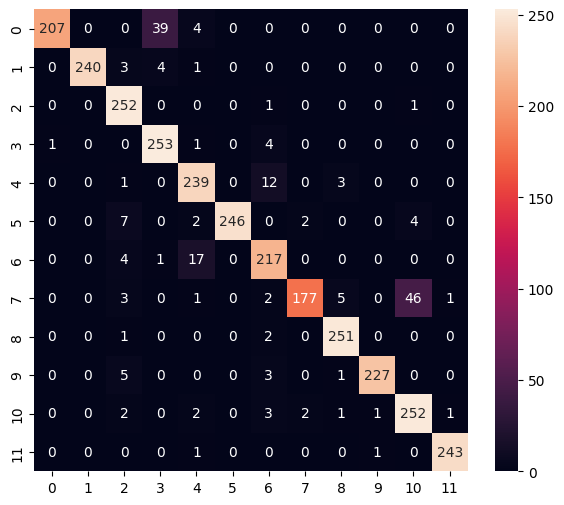

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.90       250
           1       1.00      0.97      0.98       248
           2       0.91      0.99      0.95       254
           3       0.85      0.98      0.91       259
           4       0.89      0.94      0.91       255
           5       1.00      0.94      0.97       261
           6       0.89      0.91      0.90       239
           7       0.98      0.75      0.85       235
           8       0.96      0.99      0.97       254
           9       0.99      0.96      0.98       236
          10       0.83      0.95      0.89       264
          11       0.99      0.99      0.99       245

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.94      0.93      0.93      3000



In [17]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)